# MSNP

In this notebook I demonstrate how you can use MSNP network for human pose estimation.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.transforms as transforms

from network import MSPN
from config import get_config
from test import get_image_from_url

### Loading

First we load the model from the GDrive link given in the repo README and place it on this same level as this notebook.

In [2]:
cfg = get_config("coco")

In [3]:
model = MSPN(cfg)

In [4]:
state_dict = torch.load("drive-download-20210107T043037Z-001/mspn_2xstg_coco.pth", map_location="cpu")
state_dict = state_dict['model']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [174]:
two_cricket_players = get_image_from_url("https://as1.ftcdn.net/jpg/02/02/34/06/500_F_202340607_5hLNnSTaw5VceN4rxsgeAOtGyGTaDiB9.jpg")

fetching https://as1.ftcdn.net/jpg/02/02/34/06/500_F_202340607_5hLNnSTaw5VceN4rxsgeAOtGyGTaDiB9.jpg


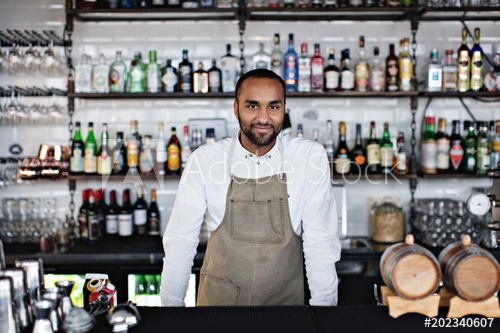

In [175]:
two_cricket_players

In [176]:
# define the image transformations to apply to each image
image_transformations = transforms.Compose([
    transforms.Resize((256, 192)),                               # resize to a (256,256) image
    transforms.ToTensor(),                                # convert to tensor
    transforms.Normalize(cfg.INPUT.MEANS, cfg.INPUT.STDS),    # normalise image according to imagenet valuess
])

In [177]:
out = image_transformations(two_cricket_players)
out.size()

torch.Size([3, 256, 192])

In [178]:
outputs = model(out.view(1, *out.size()))
outputs = outputs.detach().numpy()
outputs.shape

(1, 17, 64, 48)

In [179]:
kernel=11
shifts=[0.25]

nr_img = outputs.shape[0]
preds = np.zeros((nr_img, cfg.DATASET.KEYPOINT.NUM, 2))
maxvals = np.zeros((nr_img, cfg.DATASET.KEYPOINT.NUM, 1))
for i in range(nr_img):
    score_map = outputs[i].copy()
    score_map = score_map / 255 + 0.5
    kps = np.zeros((cfg.DATASET.KEYPOINT.NUM, 2))
    scores = np.zeros((cfg.DATASET.KEYPOINT.NUM, 1))
    border = 10
    dr = np.zeros((cfg.DATASET.KEYPOINT.NUM,
        cfg.OUTPUT_SHAPE[0] + 2 * border, cfg.OUTPUT_SHAPE[1] + 2 * border))
    dr[:, border: -border, border: -border] = outputs[i].copy()
    for w in range(cfg.DATASET.KEYPOINT.NUM):
        dr[w] = cv2.GaussianBlur(dr[w], (kernel, kernel), 0)
    for w in range(cfg.DATASET.KEYPOINT.NUM):
        for j in range(len(shifts)):
            if j == 0:
                lb = dr[w].argmax()
                y, x = np.unravel_index(lb, dr[w].shape)
                dr[w, y, x] = 0
                x -= border
                y -= border
            lb = dr[w].argmax()
            py, px = np.unravel_index(lb, dr[w].shape)
            dr[w, py, px] = 0
            px -= border + x
            py -= border + y
            ln = (px ** 2 + py ** 2) ** 0.5
            if ln > 1e-3:
                x += shifts[j] * px / ln
                y += shifts[j] * py / ln
        x = max(0, min(x, cfg.OUTPUT_SHAPE[1] - 1))
        y = max(0, min(y, cfg.OUTPUT_SHAPE[0] - 1))
        kps[w] = np.array([x * 4 + 2, y * 4 + 2])
        scores[w, 0] = score_map[w, int(round(y) + 1e-9), int(round(x) + 1e-9)]
        
        preds[i] = kps
        maxvals[i] = scores

In [180]:
preds

array([[[101.,  86.],
        [106.,  81.],
        [ 94.,  79.],
        [110.,  81.],
        [ 90.,  81.],
        [118., 117.],
        [ 78., 119.],
        [122., 165.],
        [ 70., 167.],
        [125., 218.],
        [ 66., 215.],
        [117., 210.],
        [ 86., 211.],
        [114., 249.],
        [101., 250.],
        [110., 249.],
        [107., 250.]]])

In [181]:
def visualize(img, joints):
    pairs = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
            [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
            [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]
    color = np.random.randint(0, 256, (len(pairs), 3)).tolist()

    for i in range(2):
        if joints[i, 0] > 0 and joints[i, 1] > 0:
            cv2.circle(img, tuple(joints[i, :2]), 2, tuple(color[i]), 2)

    def draw_line(img, p1, p2, c):
        if p1[0] > 0 and p1[1] > 0 and p2[0] > 0 and p2[1] > 0:
            cv2.line(img, tuple(p1), tuple(p2), c, 2)

    for i, pair in enumerate(pairs):
        draw_line(img, joints[pair[0] - 1], joints[pair[1] - 1], color[i])

    return img

In [182]:
resize = two_cricket_players.resize((192, 256))
cv2img = cv2.cvtColor(np.array(resize), cv2.COLOR_RGB2BGR)
cv2img = cv2.cvtColor(cv2img, cv2.COLOR_RGB2BGR)
out_img = visualize(cv2img, preds[0].astype(int))
out_img = cv2.resize(out_img, (256, 192))

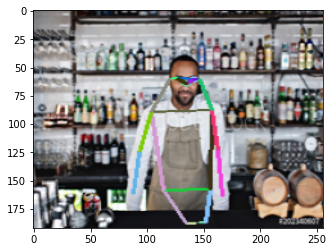

In [183]:
plt.imshow(out_img)

In [185]:
import os.path as osp

In [186]:
osp.dirname("/Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py")

'/Users/yashbonde/Desktop/wrk/model_runs/MSPN'

In [193]:
(cfg.INPUT.MEANS, cfg.INPUT.STDS)

([0.406, 0.456, 0.485], [0.225, 0.224, 0.229])